In [1]:
!pip install tensorflow-addons

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

In [2]:
# Load data
X_train = np.load('/content/DataForClassification_TimeDomain.npy')
X_train = np.transpose(X_train)
print(X_train.shape)

(936, 3600)


In [3]:
# labels
Y_train = np.zeros((936, 1))
label = 0

for i in range(936):
    Y_train[i] = label
    if i % 104 == 0 and i != 0:
        label += 1

# one hot encoding
Y_train = np.eye(9)[Y_train.astype(int).flatten()]

In [4]:
# Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.125, random_state=0)  # 0.125 x 0.8 = 0.1

In [8]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_test = np.array(Y_test)

In [9]:
# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
X_val = torch.from_numpy(X_val).float()
X_test = torch.from_numpy(X_test).float()
Y_train = torch.from_numpy(Y_train).float()
Y_val = torch.from_numpy(Y_val).float()
Y_test = torch.from_numpy(Y_test).float()

# Create Dataloaders
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=1)

In [16]:
# Define model
class GRUModel(nn.Module):
    def __init__(self):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=3600, hidden_size=32, num_layers=1, batch_first=True)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32, 8)
        self.fc2 = nn.Linear(8, 9)

    def forward(self, x):
      out, _ = self.gru(x)
      out = self.flatten(out)
      out = F.relu(self.fc1(out))  # Apply ReLU activation after the linear transformation
      out = self.fc2(out)
      return out

In [17]:
# Instantiate model and define loss function and optimizer
model = GRUModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [19]:
# Training loop
num_epochs = 50
batch_size = 64

for epoch in range(num_epochs):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(criterion(model(data), target) for data, target in val_loader)
    print(f'Epoch {epoch + 1}, Validation Loss: {valid_loss.item()}')


Epoch 1, Validation Loss: 0.2602686882019043
Epoch 2, Validation Loss: 0.2595467269420624
Epoch 3, Validation Loss: 0.26103079319000244
Epoch 4, Validation Loss: 0.2623788118362427
Epoch 5, Validation Loss: 0.26183202862739563
Epoch 6, Validation Loss: 0.2598229646682739
Epoch 7, Validation Loss: 0.25611716508865356
Epoch 8, Validation Loss: 0.25425997376441956
Epoch 9, Validation Loss: 0.2529585659503937
Epoch 10, Validation Loss: 0.25070956349372864
Epoch 11, Validation Loss: 0.24940335750579834
Epoch 12, Validation Loss: 0.24774566292762756
Epoch 13, Validation Loss: 0.24513304233551025
Epoch 14, Validation Loss: 0.24451862275600433
Epoch 15, Validation Loss: 0.24205847084522247
Epoch 16, Validation Loss: 0.24214056134223938
Epoch 17, Validation Loss: 0.24298253655433655
Epoch 18, Validation Loss: 0.2435712218284607
Epoch 19, Validation Loss: 0.24436287581920624
Epoch 20, Validation Loss: 0.24361184239387512
Epoch 21, Validation Loss: 0.24041183292865753
Epoch 22, Validation Loss: 0

In [20]:
# Save the model
torch.save(model.state_dict(), '/content/nn_model.pth')

In [26]:
predicted_labels = torch.argmax(F.softmax(model(X_test), dim=-1), dim=-1).squeeze().long()
true_labels = torch.argmax(Y_test.squeeze(), dim=-1).long()

accuracy = accuracy_score(true_labels.numpy(), predicted_labels.numpy())
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate test loss
test_loss = criterion(model(X_test), F.one_hot(true_labels, num_classes=9).float())
print(f'Test Loss: {test_loss.item()}')

Accuracy: 95.74%
Test Loss: 0.2538639307022095


Confusion Matrix:
[[19  0  0  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0  0  0]
 [ 0  0 23  0  0  0  0  0  0]
 [ 0  0  0 17  0  0  2  1  0]
 [ 0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0 19  1  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0 21  0]
 [ 0  0  0  1  0  0  0  3 17]]


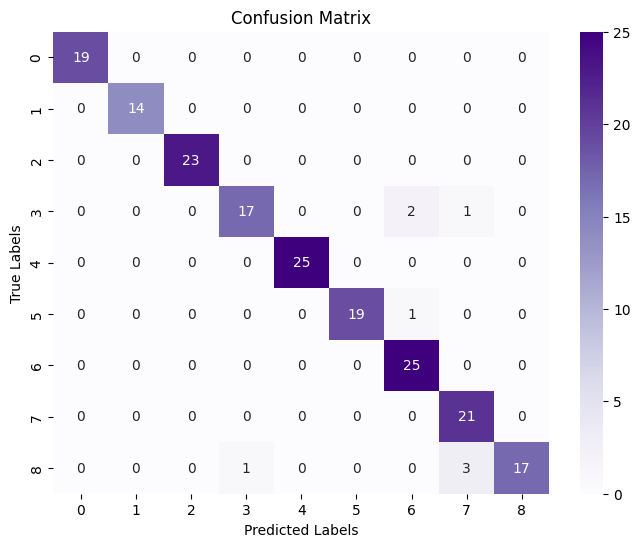

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
confusion_matrix = confusion_matrix(true_labels.numpy(), predicted_labels.numpy())
print("Confusion Matrix:")
print(confusion_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot= True, cmap="Purples")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()